# Imports

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data generation

Data taken from Kaggle, Happiness Index dataset

In [9]:
import pandas as pd

dataset = pd.read_csv('./data/2019.csv', index_col='Overall rank')
data = dataset[['GDP per capita', 'Score']]

In [10]:
X = data[data.columns[0]]
y = data[data.columns[1]]

In [11]:
def plot_data(X, y):
    plt.plot(X, y, 'k.', markersize=2)

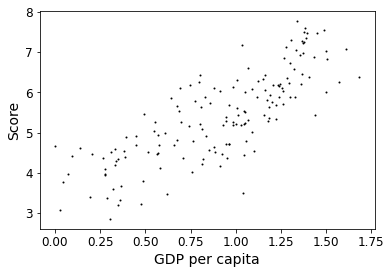

In [12]:
plt.xlabel('GDP per capita')
plt.ylabel('Score')
plot_data(X, y)

# Cluster Analysis

In [6]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(data)

Now plotting decision boundaries - code taken from Jupyter notebook

In [26]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max()/10]
        
    # plot the white circle of centroid markers
    plt.scatter(centroids[:,0], centroids[:,1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    # plot the x of the centroid markers
    plt.scatter(centroids[:,0], centroids[:,1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [27]:
def plot_decision_boundaries(clusterer, data, X, y, resolution=1000):
    # data is expected to be 2d array
    
    # Get the extremas of the dataset
    mins = data.min(axis=0) - 0.1
    maxs = data.max(axis=0) + 0.1
    
    # Create a meshgrid of using extremas as a boundary
    # Shape will be resolution X resolution
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    # Predict all datapoints within points generated by meshgrid
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plot filled contours
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap="Pastel2")
    
    # plot lines
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    plot_data(X, y)
    plot_centroids(clusterer.cluster_centers_)    

C:\Users\codeu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


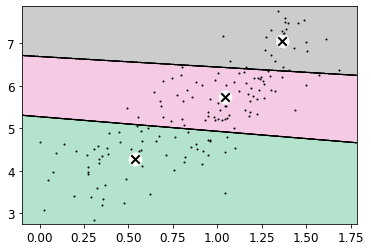

In [28]:
plot_decision_boundaries(kmeans, data, X, y)